In [9]:
import json
import numpy as np
from pp_utils import TimeStepStats, LinearSolveStats
from matplotlib import pyplot as plt
from plot_utils import *

with open("../stats/fpm_2_sliding.json", "r") as f:
    contents = json.load(f)

data = [TimeStepStats.from_json(x) for x in contents]

Text(0.5, 0, '# matrix')

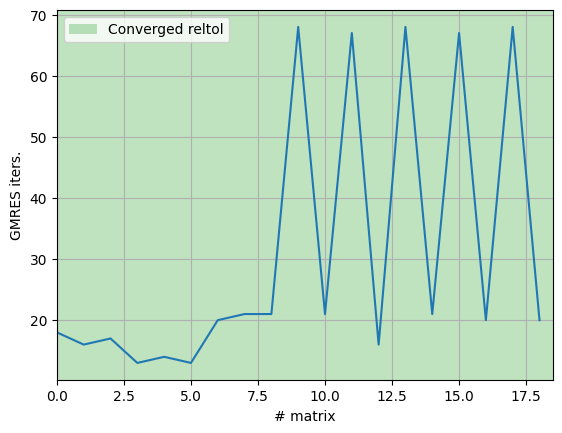

In [10]:
# %matplotlib ipympl

color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')

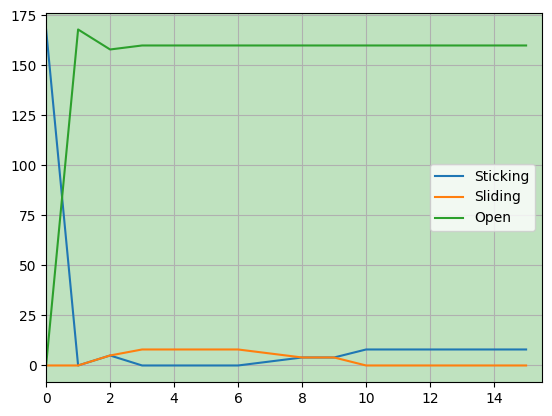

In [3]:
sticking, sliding, open_ = get_num_sticking_sliding_open(data)
color_converged_reason(data, legend=False)
plt.plot(sticking, label='Sticking')
plt.plot(sliding, label='Sliding')
plt.plot(open_, label='Open')
plt.legend()

In [5]:
import scipy.sparse
from pathlib import Path
from plot_utils import *


mat, rhs = load_matrix_rhs(data, 1)
# spy(mat)
# plt.plot(abs(rhs))
# plt.yscale('log')

In [6]:
import porepy as pp
import numpy as np   
from mat_utils import *
from plot_utils import *
from fpm_2 import make_model
from pp_utils import make_row_col_dofs

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.2


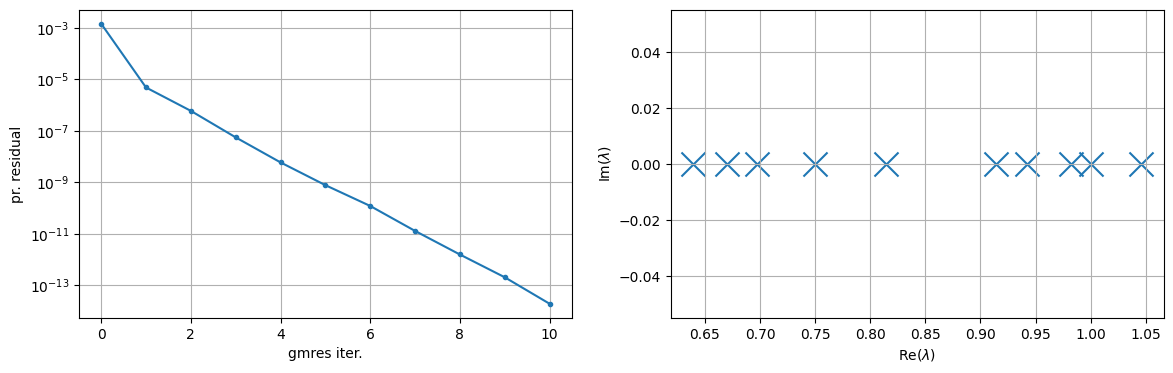

In [7]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

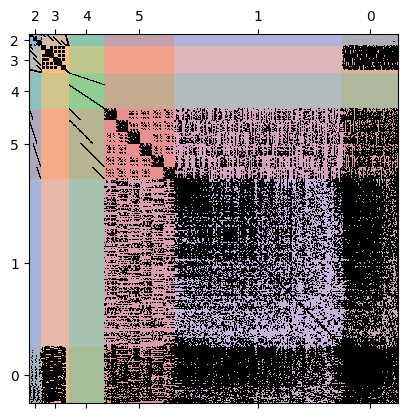

In [8]:
perm_mat.color_spy()